# Trabalho 5

* Aluno : Gabriel Borin Macedo
* RA : 197201

## Descrição do trabalho

O objetivo deste trabalho é detectar movimentos por meio da comparação de imagens capturadas por uma câmera de vı́deo ou até mesmo de um próprio vídeo. Isso será feito criando _bouding boxes_ nas regiões que contém movimento.

### Parte 1 : Conceitos para a detecção de movimento em uma _webcam_

A detecção de movimento é realizada da seguinte forma :

* 1 — o quadro atual e o anterior são convertidos em escala BRG (já que estamos utilizando o _opencv_ e este utiliza este padrão) para a escala em tons de cinza.
* 2 — é feita a diferença entre o quadro atual e o anterior.
* 3 — é aplicado uma suavização gaussiano na diferença dos quadros.
* 4 — é aplicado um processo de limiarização na diferença após a imagem suavizada.
* 5 — é aplicado uma dilatação na imagem limiarizada para adicionar os _pixels_ de bordas dos objetos.

Além disso, iremos considerar a ocorência de movimento se a área de um objeto presenta na diferença de dois quadros correntes forem **maiores que um limiar T**. Caso isto ocorra, então será apresentado na tela retângulos envolventes dos contornos das áreas que são maiores que este limiar T. Todo esse processo será feito em quadro corrente do vídeo.

Desta forma, abaixo vamos definir uma função que realize esta tarefa

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from numpy.random import randint, seed

# Dicionário que contém o tipo de arquivo de imagem que será salvo
__extensions_to_save_vid = {
    "mp4": cv2.VideoWriter_fourcc(*'mp4v'),
    "avi": cv2.VideoWriter_fourcc(*'MJPG')
}


def create_video_capture(input_dir: str = "VideoEntrada/", video_name_input: str = "Input",
                         frames: float = 30.0, save_dir: str = "Resultados/VideoIterativo/",
                         video_ext: str = "mp4", **kwargs: any) -> tuple[
    dict[int, np.ndarray], dict[int, np.ndarray],
    dict[int, np.ndarray], dict[int, np.ndarray]]:
    """
    Função que realiza a captura de vídeo utilizando uma webcam e detecta se há movimento. Caso a região seja uma região de movimento, então será feito
    um retângulo envolvente na região durante o quadro corrente.

    Args:
        input_dir (str): diretório para salvar o vídeo
        video_name_input (str): nome do vídeo para ser salvo
        frames (float): quantidade de quadros para salvar o vídeo
        save_dir (str): diretório para salvar
        video_ext (str): extensão do vídeo
        **kwargs (any): dicionário que contém os parâmetros opcionais para a captura do video. Estes parâmetros são aplicado para os processos de pré-processamento dos quadros

    Returns:
        (tuple[dict[int, np.ndarray], dict[int, np.ndarray], dict[int, np.ndarray], dict[int, np.ndarray]]) : Esta função retorna 4 dicionários que contém respectivamente os quadros da imagem original capturada diretamente da webcam, os quadros do vídeo na escala de cinza e com os retângulos, os quadros do vídeo com a operação de dilatação e com os retângulos e os quadros do vídeo capturado diretamente da webcam com os retângulos envolventes na região com movimento.

    """
    if "k_size" in kwargs.keys():
        k_size = kwargs.pop("k_size")

    else:
        k_size = (5, 5)

    if "d_size" in kwargs.keys():
        d_size = kwargs.pop("d_size")

    else:
        d_size = None

    if "sigma" in kwargs.keys():
        sigma = kwargs.pop("sigma")

    else:
        sigma = 0.0

    if "n_iterations_di" in kwargs.keys():
        n_iterations_di = kwargs.pop("n_iterations_di")

    else:
        n_iterations_di = 3

    if "t_min" in kwargs.keys():
        t_min = kwargs.pop("t_min")

    else:
        t_min = 20

    if "t_max" in kwargs.keys():
        t_max = kwargs.pop("t_max")

    else:
        t_max = 255

    if "area_threshold" in kwargs.keys():
        area_threshold = kwargs.pop("area_threshold")

    else:
        area_threshold = 900

    # Verificando se a extensão é mp4 ou avi
    assert video_ext in __extensions_to_save_vid.keys(), "a opção {} é inválida para conversão de vídeo. Escolha entre mp4 ou avi".format(
        video_ext)

    # Criando o objeto da camera
    video = cv2.VideoCapture(0)

    # dicionários que conterão os frames capturados
    i = 0
    video_frames_original = {}
    video_frames_gray = {}
    video_frames_dilated = {}
    video_frames_output = {}

    # verificando se a camera está aberta, caso ela não esteja, printamos uma mensagem de erro na tela
    if (video.isOpened() == False):
        print("Error reading video file")

    # Pegando a resoluçã do vídeo
    frame_width = int(video.get(3))
    frame_height = int(video.get(4))

    size = (frame_width, frame_height)

    os.makedirs(input_dir, exist_ok=True)
    os.makedirs(save_dir, exist_ok=True)

    # Nesta parte, estamos criando os objetos de
    video_reader_input = cv2.VideoWriter(
        "{}{}.{}".format(input_dir, video_name_input, video_ext),
        __extensions_to_save_vid[video_ext],
        frames, size)

    video_reader_gray = cv2.VideoWriter("{}/GrayImg.{}".format(save_dir, video_ext),
                                        __extensions_to_save_vid[video_ext],
                                        frames, size)

    video_reader_dilated = cv2.VideoWriter(
        "{}DilatedImg.{}".format(save_dir, video_ext),
        __extensions_to_save_vid[video_ext],
        frames, size)

    video_reader_output = cv2.VideoWriter(
        "{}Output.{}".format(save_dir, video_ext),
        __extensions_to_save_vid[video_ext],
        frames, size)

    _, frame_1 = video.read()
    _, frame_2 = video.read()

    while video.isOpened():

        # Nesta parte, estamos salvando o primeiro frame como RGB, já que originalmente
        # O opencv salva imagens sendo BGR, basta pegar os valores de trás para frente
        video_frames_original[i] = frame_1[:, :, ::-1].copy()
        video_reader_input.write(frame_1)

        # Este frame será guardado apenas para montar posteriormente o quadro em tom de cinza como vídeo
        frame_1_gray = cv2.cvtColor(frame_1, cv2.COLOR_BGR2GRAY)

        # Está é a parte que tiramos as difenreças entre os quadros
        diff_img = cv2.absdiff(frame_1, frame_2)

        # Transformamos a difenrença em uma imagem monocromática
        diff_gray = cv2.cvtColor(diff_img, cv2.COLOR_BGR2GRAY)

        # Aplicamos uma suavização gaussiana para remover os ruídos
        blur = cv2.GaussianBlur(diff_gray, k_size, sigma)

        # Aplicamos uma operação de ‘threshold’ na imagem para segmentar os objetos
        _, thresh = cv2.threshold(blur, t_min, t_max, cv2.THRESH_BINARY)

        # Aplicamos um processo de dilatação na imagem
        dilated = cv2.dilate(thresh, d_size, iterations=n_iterations_di)

        # Agora, encontramos os contornos dos objetos
        contours, _ = cv2.findContours(
            dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        new_frame_blur_img = np.zeros(shape=(frame_1_gray.shape[0], frame_1_gray.shape[1], 3), dtype=frame_1_gray.dtype)
        new_frame_blur_img[:, :, 0] = frame_1_gray
        new_frame_blur_img[:, :, 1] = frame_1_gray
        new_frame_blur_img[:, :, 2] = frame_1_gray

        new_frame_dilated_img = np.zeros(shape=(dilated.shape[0], dilated.shape[1], 3), dtype=dilated.dtype)
        new_frame_dilated_img[:, :, 0] = dilated
        new_frame_dilated_img[:, :, 1] = dilated
        new_frame_dilated_img[:, :, 2] = dilated

        # Nesta parte, criamos os retângulos caso eles sejam maiores que um limiar
        for contour in contours:
            (x, y, w, h) = cv2.boundingRect(contour)
            if cv2.contourArea(contour) > area_threshold:
                cv2.rectangle(frame_1, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(frame_1, "Status: {}".format('Movement'), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                            0.8, (0, 255, 0), 3)

                # Podemos também desenhar estes retângulos nas imagens em tons de cinza ou até mesmo na imagem dilatada
                # cv2.rectangle(new_frame_blur_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                # cv2.putText(new_frame_blur_img, "Status: {}".format('Movement'), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                #             0.8, (0, 255, 0), 3)
                #
                # cv2.rectangle(new_frame_dilated_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                # cv2.putText(new_frame_dilated_img, "Status: {}".format('Movement'), (x, y - 10),
                #             cv2.FONT_HERSHEY_SIMPLEX,
                #             0.8, (0, 255, 0), 3)

        video_frames_gray[i] = new_frame_blur_img
        video_frames_dilated[i] = new_frame_dilated_img
        video_frames_output[i] = frame_1[:, :, ::-1]
        i += 1

        cv2.imshow("Video", frame_1)
        video_reader_gray.write(new_frame_blur_img)
        video_reader_dilated.write(new_frame_dilated_img)
        video_reader_output.write(frame_1)

        frame_1 = frame_2
        ret, frame_2 = video.read()

        # Aperte "q" caso queira parar de realizar a captura do vídeo
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    # Finalizando a captura de vídeo
    video.release()
    video_reader_input.release()
    video_reader_gray.release()
    video_reader_dilated.release()
    video_reader_output.release()

    # Fechando todos os frames da imagem
    cv2.destroyAllWindows()
    return video_frames_original, video_frames_gray, video_frames_dilated, video_frames_output

In [2]:
input_frames, gray_frames, dilated_frames, output_frames = create_video_capture(frames=30.0, video_ext="avi")

Agora, vamos visualizar alguns quadros capturados

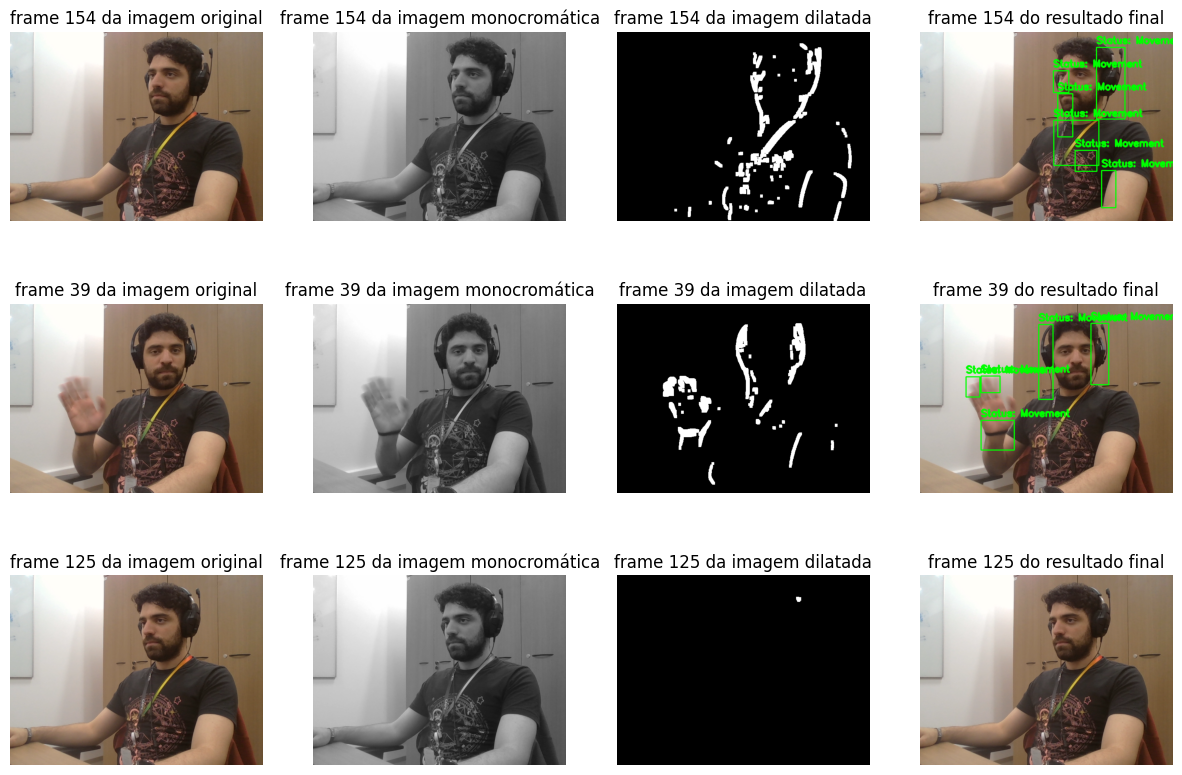

In [3]:
n_frames_to_print = 3

_, ax = plt.subplots(n_frames_to_print, 4, figsize=(15, 10))

seed(55)
frame_index_vec = randint(0, len(output_frames), n_frames_to_print)

for i in range(0, n_frames_to_print):
    frame_index = frame_index_vec[i]

    ax[i, 0].imshow(input_frames[frame_index], vmin=input_frames[frame_index].min(),
                    vmax=input_frames[frame_index].max())
    ax[i, 0].set_title("frame {} da imagem original".format(frame_index))
    ax[i, 0].axis("off")

    ax[i, 1].imshow(gray_frames[frame_index], vmin=gray_frames[frame_index].min(), vmax=gray_frames[frame_index].max())
    ax[i, 1].set_title("frame {} da imagem monocromática".format(frame_index))
    ax[i, 1].axis("off")

    ax[i, 2].imshow(dilated_frames[frame_index], vmin=dilated_frames[i].min(), vmax=dilated_frames[i].max())
    ax[i, 2].set_title("frame {} da imagem dilatada".format(frame_index))
    ax[i, 2].axis("off")

    ax[i, 3].imshow(output_frames[frame_index], vmin=output_frames[i].min(), vmax=output_frames[i].max())
    ax[i, 3].set_title("frame {} do resultado final".format(frame_index))
    ax[i, 3].axis("off")

plt.savefig("Resultados/resultadosFramesWeb.png")
plt.show()

#### Criação da função que salva esses frames em extensão .gif

Após registramos cada frame, iremos pegar cada um destes quadros e carregar um arquivo .gif para esta tarefa

In [4]:
from imageio import mimsave


def save_gif(file_name: str, frames_dict: dict[int, np.ndarray], fps_val: float = 30.0) -> None:
    """
    Função que dado um dicionário que contém os frames de um vídeo, salva eles em extensão .gif

    Args:
        file_name (str): nome do arquivo gif para ser salvo
        frames_dict (dict[int, np.ndarray]): dicionário que contém os frames para serem salvos
        fps_val (float): valor dos quadros

    Returns:
        None

    """

    frames_list = [*frames_dict.values()]

    mimsave("Resultados/FramesGifs/{}".format(file_name), frames_list, fps=fps_val)

Desta forma, vamos salvar cada imagem como extensão .gif e com isso, vamos ver o resultado na tela

OBS : Caso não apareça o gif no _markdown_, tente executar novamente a célula do _markdown_

##### Vídeo original

In [5]:
save_gif("input.gif", input_frames)

![display the image](Resultados/FramesGifs/input.gif)

##### Vídeo em escala monocromática

In [6]:
save_gif("gray.gif", gray_frames)

![display the image](Resultados/FramesGifs/gray.gif)

##### Vídeo com operação de dilatação

In [7]:
save_gif("dilated.gif", dilated_frames)

![display the image](Resultados/FramesGifs/dilated.gif)

##### Vídeo com as regiões de movimento

In [8]:
save_gif("output.gif", output_frames)

![display the image](Resultados/FramesGifs/output.gif)

### Parte extra : Extração de informação a partir de um vídeo

De forma intuitiva, podemos expandir essa leitura em vídeo. Desta forma, vamos pegar um exemplo.

Além disso, podemos aproveitar grande parte do código de captura de vídeo direto da camera com poucas modificações

In [9]:
def capture_motion_video(input_dir: str = "VideoEntrada/", video_name_input: str = "VideoTeste",
                         frames: float = 30.0, save_dir: str = "Resultados/VideoIterativoTeste/",
                         video_ext: str = "mp4", **kwargs: any) -> tuple[
    dict[int, np.ndarray], dict[int, np.ndarray],
    dict[int, np.ndarray], dict[int, np.ndarray]]:
    """
    Função que realiza a captura de quadros de um vídeo e detecta se há movimento. Caso a região seja uma região de movimento, então será feito
    um retângulo envolvente na região durante o quadro corrente.

    Args:
        input_dir (str): diretório para salvar o vídeo
        video_name_input (str): nome do vídeo para ser salvo
        frames (float): quantidade de quadros para salvar o vídeo
        save_dir (str): diretório para salvar
        video_ext (str): extensão do vídeo
        **kwargs (any): dicionário que contém os parâmetros opcionais para a captura do video. Estes parâmetros são aplicado para os processos de pré-processamento dos quadros

    Returns:
        (tuple[dict[int, np.ndarray], dict[int, np.ndarray], dict[int, np.ndarray], dict[int, np.ndarray]]) : Esta função retorna 4 dicionários que contém respectivamente os quadros da imagem original capturada diretamente da webcam, os quadros do vídeo na escala de cinza e com os retângulos, os quadros do vídeo com a operação de dilatação e com os retângulos e os quadros do vídeo capturado diretamente da webcam com os retângulos envolventes na região com movimento.

    """
    if "k_size" in kwargs.keys():
        k_size = kwargs.pop("k_size")

    else:
        k_size = (5, 5)

    if "d_size" in kwargs.keys():
        d_size = kwargs.pop("d_size")

    else:
        d_size = None

    if "sigma" in kwargs.keys():
        sigma = kwargs.pop("sigma")

    else:
        sigma = 0.0

    if "n_iterations_di" in kwargs.keys():
        n_iterations_di = kwargs.pop("n_iterations_di")

    else:
        n_iterations_di = 3

    if "t_min" in kwargs.keys():
        t_min = kwargs.pop("t_min")

    else:
        t_min = 20

    if "t_max" in kwargs.keys():
        t_max = kwargs.pop("t_max")

    else:
        t_max = 255

    if "area_threshold" in kwargs.keys():
        area_threshold = kwargs.pop("area_threshold")

    else:
        area_threshold = 900

    # Verificando se a extensão é mp4 ou avi
    assert video_ext in __extensions_to_save_vid.keys(), "a opção {} é inválida para conversão de vídeo. Escolha entre mp4 ou avi".format(
        video_ext)

    path = "{}{}.{}".format(input_dir, video_name_input, video_ext)

    print("path : {}".format(path))

    # Criando o objeto da camera
    video = cv2.VideoCapture("{}{}.{}".format(input_dir, video_name_input, video_ext))

    # dicionários que conterão os frames capturados
    i = 0
    video_frames_original = {}
    video_frames_gray = {}
    video_frames_dilated = {}
    video_frames_output = {}

    # verificando se a camera está aberta, caso ela não esteja, printamos uma mensagem de erro na tela
    if (video.isOpened() == False):
        print("Error reading video file")

    # Pegando a resoluçã do vídeo
    frame_width = int(video.get(3))
    frame_height = int(video.get(4))

    size = (frame_width, frame_height)

    os.makedirs(save_dir, exist_ok=True)

    video_reader_gray = cv2.VideoWriter("{}/GrayImg.{}".format(save_dir, video_ext),
                                        __extensions_to_save_vid[video_ext],
                                        frames, size)

    video_reader_dilated = cv2.VideoWriter(
        "{}DilatedImg.{}".format(save_dir, video_ext),
        __extensions_to_save_vid[video_ext],
        frames, size)

    video_reader_output = cv2.VideoWriter(
        "{}Output.{}".format(save_dir, video_ext),
        __extensions_to_save_vid[video_ext],
        frames, size)

    flag, frame_1 = video.read()
    flag, frame_2 = video.read()

    while flag:

        # Nesta parte, estamos salvando o primeiro frame como RGB, já que originalmente
        # O opencv salva imagens sendo BGR, basta pegar os valores de trás para frente
        video_frames_original[i] = frame_1[:, :, ::-1].copy()

        # Este frame será guardado apenas para montar posteriormente o quadro em tom de cinza como vídeo
        frame_1_gray = cv2.cvtColor(frame_1, cv2.COLOR_BGR2GRAY)

        # Está é a parte que tiramos as difenreças entre os quadros
        diff_img = cv2.absdiff(frame_1, frame_2)

        # Transformamos a difenrença em uma imagem monocromática
        diff_gray = cv2.cvtColor(diff_img, cv2.COLOR_BGR2GRAY)

        # Aplicamos uma suavização gaussiana para remover os ruídos
        blur = cv2.GaussianBlur(diff_gray, k_size, sigma)

        # Aplicamos uma operação de ‘threshold’ na imagem para segmentar os objetos
        _, thresh = cv2.threshold(blur, t_min, t_max, cv2.THRESH_BINARY)

        # Aplicamos um processo de dilatação na imagem
        dilated = cv2.dilate(thresh, d_size, iterations=n_iterations_di)

        # Agora, encontramos os contornos dos objetos
        contours, _ = cv2.findContours(
            dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        new_frame_blur_img = np.zeros(shape=(frame_1_gray.shape[0], frame_1_gray.shape[1], 3), dtype=frame_1_gray.dtype)
        new_frame_blur_img[:, :, 0] = frame_1_gray
        new_frame_blur_img[:, :, 1] = frame_1_gray
        new_frame_blur_img[:, :, 2] = frame_1_gray

        new_frame_dilated_img = np.zeros(shape=(dilated.shape[0], dilated.shape[1], 3), dtype=dilated.dtype)
        new_frame_dilated_img[:, :, 0] = dilated
        new_frame_dilated_img[:, :, 1] = dilated
        new_frame_dilated_img[:, :, 2] = dilated

        # Nesta parte, criamos os retângulos caso eles sejam maiores que um limiar
        for contour in contours:
            (x, y, w, h) = cv2.boundingRect(contour)
            if cv2.contourArea(contour) > area_threshold:
                cv2.rectangle(frame_1, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(frame_1, "Status: {}".format('Movement'), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                            0.8, (0, 255, 0), 3)

                # Podemos também desenhar estes retângulos nas imagens em tons de cinza ou até mesmo na imagem dilatada
                # cv2.rectangle(new_frame_blur_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                # cv2.putText(new_frame_blur_img, "Status: {}".format('Movement'), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                #             0.8, (0, 255, 0), 3)
                #
                # cv2.rectangle(new_frame_dilated_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                # cv2.putText(new_frame_dilated_img, "Status: {}".format('Movement'), (x, y - 10),
                #             cv2.FONT_HERSHEY_SIMPLEX,
                #             0.8, (0, 255, 0), 3)

        video_frames_gray[i] = new_frame_blur_img
        video_frames_dilated[i] = new_frame_dilated_img
        video_frames_output[i] = frame_1[:, :, ::-1]
        i += 1

        video_reader_gray.write(new_frame_blur_img)
        video_reader_dilated.write(new_frame_dilated_img)
        video_reader_output.write(frame_1)

        frame_1 = frame_2
        flag, frame_2 = video.read()

        # Aperte "q" caso queira parar de realizar a captura do vídeo
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    # Finalizando a captura de vídeo
    video.release()
    video_reader_gray.release()
    video_reader_dilated.release()
    video_reader_output.release()

    # Fechando todos os frames da imagem
    cv2.destroyAllWindows()
    return video_frames_original, video_frames_gray, video_frames_dilated, video_frames_output

In [10]:
input_frames, gray_frames, dilated_frames, output_frames = capture_motion_video(video_name_input="video480p_clip", video_ext="mp4", area_threshold=875)

path : VideoEntrada/video480p_clip.mp4


Agora, vamos verificar alguns frames do vídeo carregado

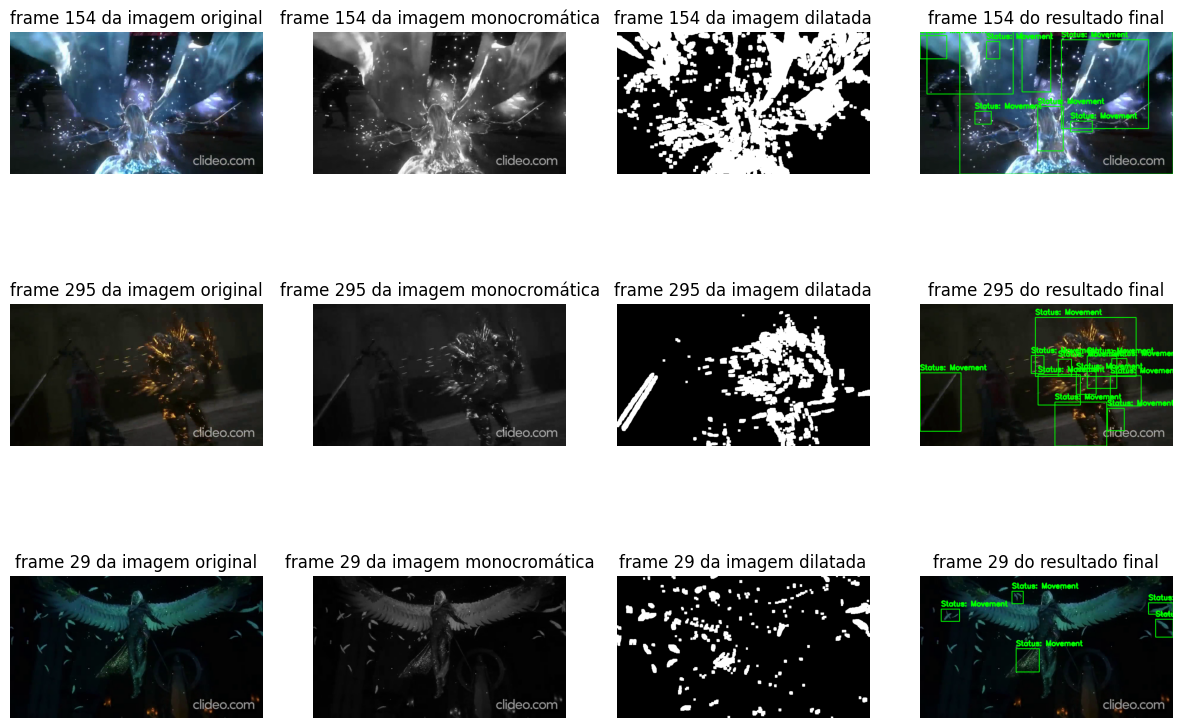

In [11]:
n_frames_to_print = 3

_, ax = plt.subplots(n_frames_to_print, 4, figsize=(15, 10))

seed(55)
frame_index_vec = randint(0, len(output_frames), n_frames_to_print)

for i in range(0, n_frames_to_print):
    frame_index = frame_index_vec[i]

    ax[i, 0].imshow(input_frames[frame_index], vmin=input_frames[frame_index].min(),
                    vmax=input_frames[frame_index].max())
    ax[i, 0].set_title("frame {} da imagem original".format(frame_index))
    ax[i, 0].axis("off")

    ax[i, 1].imshow(gray_frames[frame_index], vmin=gray_frames[frame_index].min(), vmax=gray_frames[frame_index].max())
    ax[i, 1].set_title("frame {} da imagem monocromática".format(frame_index))
    ax[i, 1].axis("off")

    ax[i, 2].imshow(dilated_frames[frame_index], vmin=dilated_frames[i].min(), vmax=dilated_frames[i].max())
    ax[i, 2].set_title("frame {} da imagem dilatada".format(frame_index))
    ax[i, 2].axis("off")

    ax[i, 3].imshow(output_frames[frame_index], vmin=output_frames[i].min(), vmax=output_frames[i].max())
    ax[i, 3].set_title("frame {} do resultado final".format(frame_index))
    ax[i, 3].axis("off")

plt.savefig("Resultados/resultadosFramesVideo.png")
plt.show()

Agora, vamos visuaizar o resultado final com a detecção de movimento

#### Video original

In [12]:
save_gif("input_video_teste.gif", input_frames)

![video teste](Resultados/FramesGifs/input_video_teste.gif)

##### Vídeo monocromático

In [13]:
save_gif("gray_video_teste.gif", gray_frames)

![video teste](Resultados/FramesGifs/gray_video_teste.gif)

##### Vídeo com operação de dilatação

In [14]:
save_gif("dilated_video_teste.gif", dilated_frames)

![video teste](Resultados/FramesGifs/dilated_video_teste.gif)

##### Vídeo com as regiões de movimento

In [15]:
save_gif("output_video_teste.gif", output_frames)

![video teste](Resultados/FramesGifs/output_video_teste.gif)